# Overview of concepts

In [2]:
# Imports 
import numpy as np 
from matplotlib import pyplot 
%matplotlib inline

## 1/f noise 

The most commonly encountered form of noise is white-noise. White-noise describes random, gaussian distributed variations that have all the typical statistical properties you might expect. For example for a set of random variables $x$ drawn from a white noise distribution the mean is 
$$
\left<x\right> = \frac{\sum{x}}{N}, 
$$
and the variance is 
$$
\sigma^2 = \left<x^2\right> - \left<x\right>^2 
$$
If you were to measure the power spectrum of $x$ (by taking the sqaure of the fourier transform) you would find that the power spectrum is flat. This is the example shown in the third plot below where $alpha = 0$. 

1/f noise is a more general description for noise. It describes noise that have power spectra that can be described as 
$$
P(\nu) = \sigma^2 \left(\frac{\nu}{\nu_k}\right)^\alpha, 
$$
where $alpha$ is the spectral index ($alpha = 0$ is white noise), $\sigma^2$ is the variance of the noise as the fourier frequency $\nu_k$. If you generate noise with $\alpha <0$ you get correlations between the samples of $x$. Some interesting properties of this noise is that the variance is $\sigma^2 = \infty$ at $N = \infty$, which means that as $N$ increases, the variance will increase.

Referenecs:
- Chapter 4 of Tools of Radio Astronomy
- 1/f noise and other systematic effects in the Planck-LFI radiometers: https://arxiv.org/abs/astro-ph/0206093 

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


/Users/user/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/user/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


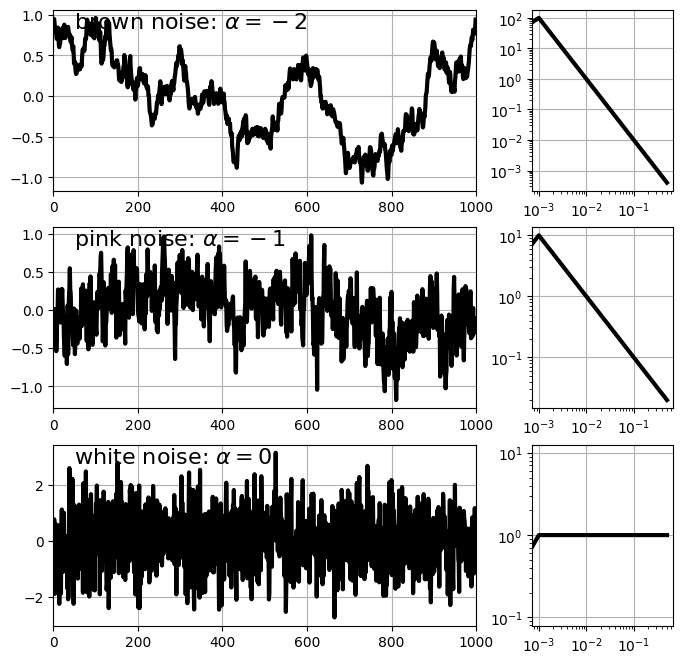

In [3]:
def generate_fnoise(alpha, rms=1, N=1000, nu0=1):
    """Generate 1/f noise 
    
    alpha - spectral index of noise
    """
    wn = np.random.normal(size=N, scale=rms)

    # Fourier transform white noise
    f_wn = np.fft.fft(wn)
    nu = np.fft.fftfreq(N)
    
    power_spectrum = np.zeros_like(f_wn)

    # Avoid division by zero, ignore index 0
    power_spectrum[1:] = np.abs(nu[1:]/nu0)**(alpha) 

    # Multiply white noise by sqrt of power spectrum
    f_noise = f_wn * power_spectrum**0.5

    # Inverse Fourier transform
    noise = np.fft.ifft(f_noise)

    ps = power_spectrum[:N//2]
    nu = nu[:N//2]
    return noise.real, nu, ps 

alphas = [-2,-1,0]
names  = ['brown','pink','white']

fig, axes = pyplot.subplots(3,2,width_ratios=[3, 1],figsize=(8,8))
axes = axes.flatten()
print(axes)

for i, (alpha, name) in enumerate(zip(alphas, names)):
    noise, nu, ps = generate_fnoise(alpha,nu0=0.01)
    pyplot.sca(axes[2*i])
    pyplot.plot(noise, 'k', lw=3)
    pyplot.grid() 
    pyplot.text(0.05, 0.9, r'{} noise: $\alpha = {}$'.format(name, alpha), transform=pyplot.gca().transAxes, fontsize=16)
    pyplot.xlim(0,noise.size)
    pyplot.sca(axes[2*i+1])
    pyplot.plot(nu, ps, 'k', lw=3)
    pyplot.grid() 
    pyplot.xscale('log')
    pyplot.yscale('log') 

pyplot.show()

## Origin of 1/f noise in COMAP

1/f noise in a total power radiometer like COMAP comes from two sources: 
1) The low noise amplifiers (LNAs)
2) Fluctuations in the water column (preciptable water vapour - pwv) above the telescope. 

Generally speaking, the noise from LNAs has a spectrum closer to $\alpha = -1$ and for atmospheric fluctuations it is closer to $\alpha = -2$. 

COMAP actually as a spectroscopic backend with the following properties:
1) 26--34 GHz split into 4 bands, each band has 4096 channels that are ~2MHz wide. 
2) The incoming signal is first amplified by the LNAs before reaching the spectrometer.
3) This means that all channels share the same 1/f noise fluctuations (more or less)---this is important for later!


## 1/f noise in maps 

The effect of 1/f noise in maps is shown below. To create a map from radio telescope data like COMAP we first define the data in terms of the map like this: 
$$
x = Pm + n
$$
where $P$ is called a pointing matrix and contains 1's and 0's with dimensions (N_data, N_pixels), $x$ is the set of measured data (N_data, 1); and $n$ is the noise added to the system from the telescope or atmosphere. 

To create a map of we use something called the map making equation:
$$
\hat{m} = (P^T N^{-1} P)^{-1} P^T N^{-1} x
$$
$N = \mathrm{E}(n n^T)$ is the noise matrix, which is diagonal for white noise ($\alpha=0$) or a dense toeplitz-like matrix if $\alpha < 0$. $\hat{m}$ is the maximum likelihood estimate of the map. If the noise is white then this equation is just the weighted average of the data in each pixel. 

References (if you are interested!):
- Fast and precise map-making for massively multi-detector CMB experiments: https://arxiv.org/abs/0912.2738


Text(0.05, 0.9, '$\\alpha = 0$')

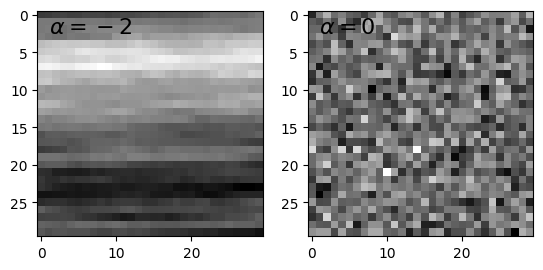

In [4]:
def create_image(noise, imgx=256, imgy=256):
    """Create an image from a 1D array of noise"""
    image = np.zeros((imgx, imgy))
    counts = np.zeros((imgx, imgy))
    for i in range(noise.size):
        x = (i // imgy) % imgx
        y = i % imgy
        image[x,y] += noise[i]
        counts[x,y] += 1
    image[counts > 0] /= counts[counts > 0]
    return image

noise, nu, ps = generate_fnoise(-2, nu0=0.01)
image = create_image(noise,imgx=30,imgy=30)
ax = pyplot.subplot(121)
pyplot.imshow(image, cmap='gray')
pyplot.text(0.05, 0.9, r'$\alpha = -2$', transform=ax.transAxes, fontsize=16)
ax = pyplot.subplot(122)
noise, nu, ps = generate_fnoise(0, nu0=0.01)
pyplot.imshow(create_image(noise,imgx=30,imgy=30), cmap='gray')
pyplot.text(0.05, 0.9, r'$\alpha = 0$', transform=ax.transAxes, fontsize=16)
